In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm


import matplotlib.pyplot as plt
import seaborn as sns

from pyramid.arima import auto_arima

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

/Users/matt_dynasty/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Extracting data for ETH at 5 min interval. 
df_eth = pd.read_json('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1438992000&end=9999999999&period=300')
df_eth.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
0,1.75,2015-08-08 06:15:00,1.75,1.61,1.65,45.000000,75.150000,1.67
1,1.85,2015-08-08 06:20:00,1.85,1.85,1.85,7.880354,14.578655,1.85
2,1.85,2015-08-08 06:25:00,1.85,1.85,1.85,0.160000,0.296000,1.85
3,1.85,2015-08-08 06:30:00,1.85,1.85,1.85,0.089794,0.166119,1.85
4,1.85,2015-08-08 06:35:00,1.85,1.85,1.85,0.000000,0.000000,1.85


In [4]:
df_eth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321378 entries, 0 to 321377
Data columns (total 8 columns):
close              321378 non-null float64
date               321378 non-null datetime64[ns]
high               321378 non-null float64
low                321378 non-null float64
open               321378 non-null float64
quoteVolume        321378 non-null float64
volume             321378 non-null float64
weightedAverage    321378 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 22.1 MB


#### Only looking at the closing price

In [5]:
df = pd.concat([df_eth['date'], df_eth['close']], axis=1)
df.head()

,date,close
0,2015-08-08 06:15:00,1.75
1,2015-08-08 06:20:00,1.85
2,2015-08-08 06:25:00,1.85
3,2015-08-08 06:30:00,1.85
4,2015-08-08 06:35:00,1.85


#### Setting the datetime as the index.

In [6]:
df.set_index('date', inplace=True)
df.head()

,close
date,
2015-08-08 06:15:00,1.75
2015-08-08 06:20:00,1.85
2015-08-08 06:25:00,1.85
2015-08-08 06:30:00,1.85
2015-08-08 06:35:00,1.85


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321378 entries, 2015-08-08 06:15:00 to 2018-08-28 03:40:00
Data columns (total 1 columns):
close    321378 non-null float64
dtypes: float64(1)
memory usage: 4.9 MB


### Plotting the rolling mean for day, week, month.

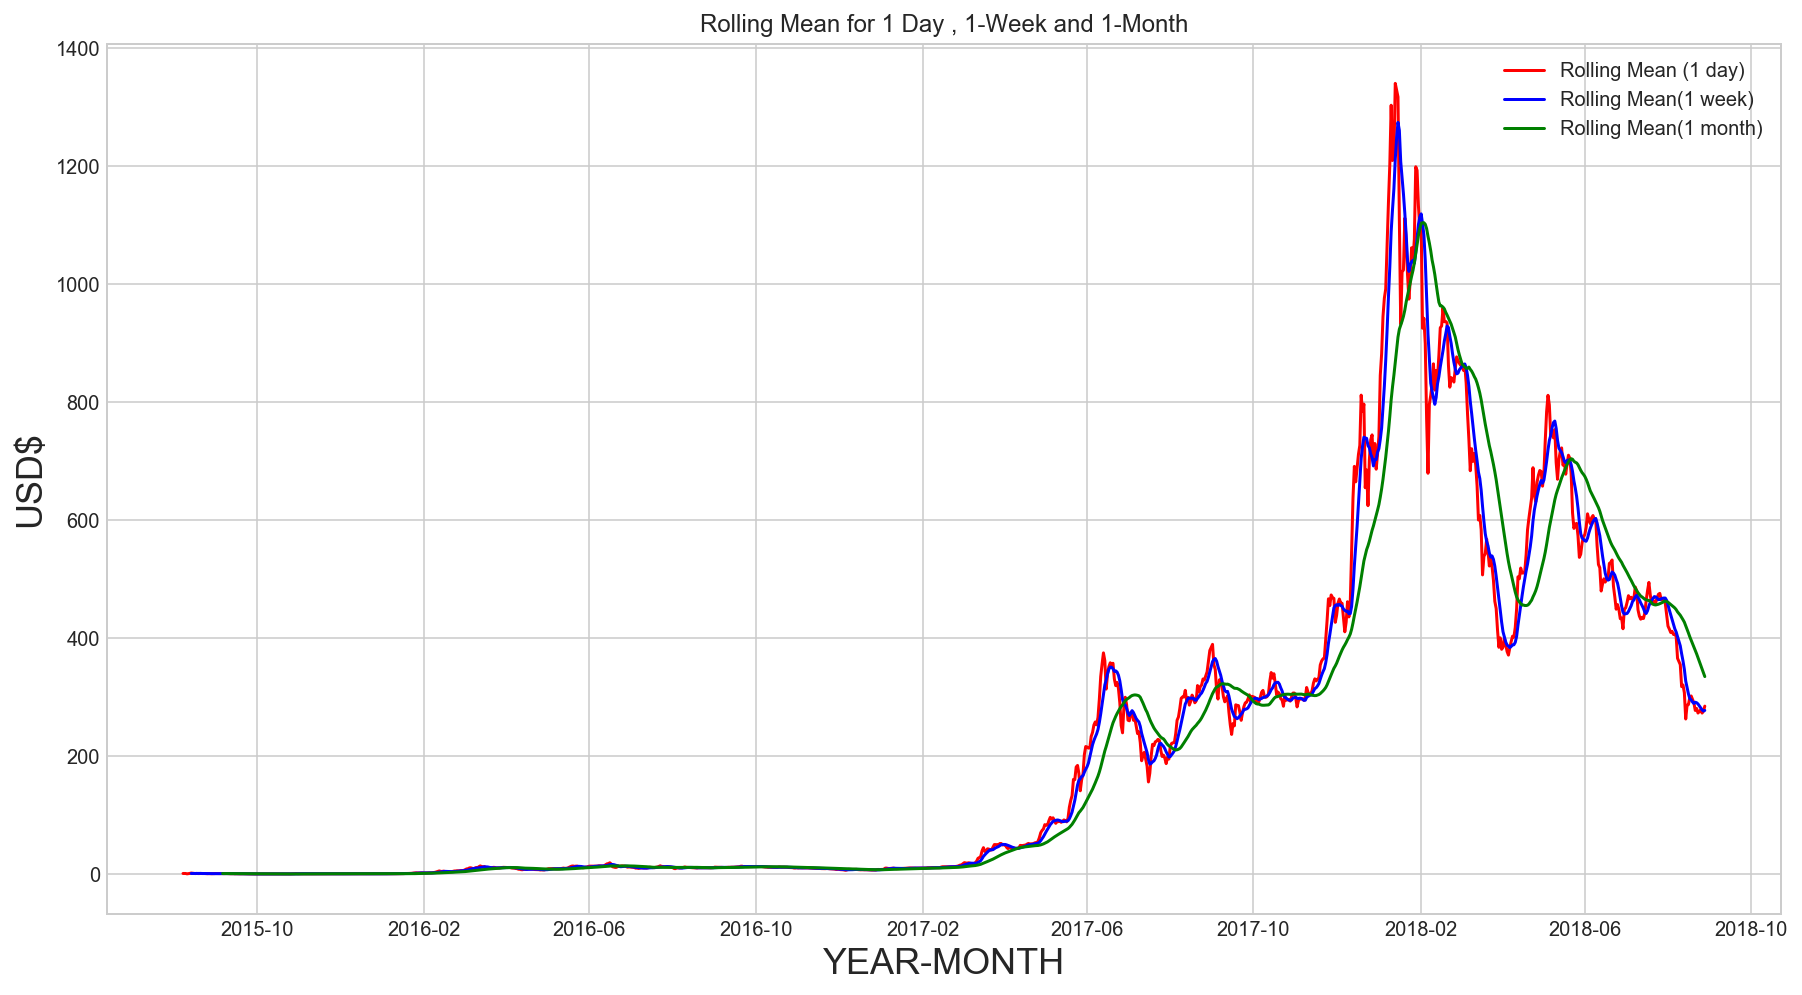

In [8]:
df_eth_dailyclosemean = df.close.resample('D').mean()

rolmean_1 = pd.rolling_mean(df_eth_dailyclosemean, window = 1)
rolmean_7 = pd.rolling_mean(df_eth_dailyclosemean, window = 7)
rolmean_30 = pd.rolling_mean(df_eth_dailyclosemean, window = 30)

fig = plt.figure(figsize=(15, 8))
mean = plt.plot(rolmean_1, color='red', label='Rolling Mean (1 day)')
mean = plt.plot(rolmean_7, color='blue', label='Rolling Mean(1 week)')
mean = plt.plot(rolmean_30, color='green', label='Rolling Mean(1 month)')

plt.legend(loc='best')
plt.title('Rolling Mean for 1 Day , 1-Week and 1-Month')
plt.ylabel('USD$', fontsize=18)
plt.xlabel('YEAR-MONTH', fontsize=18)
plt.show()

### Resample to weekly

In [9]:
df_weeklyclose = df[['close']].resample('W').mean()

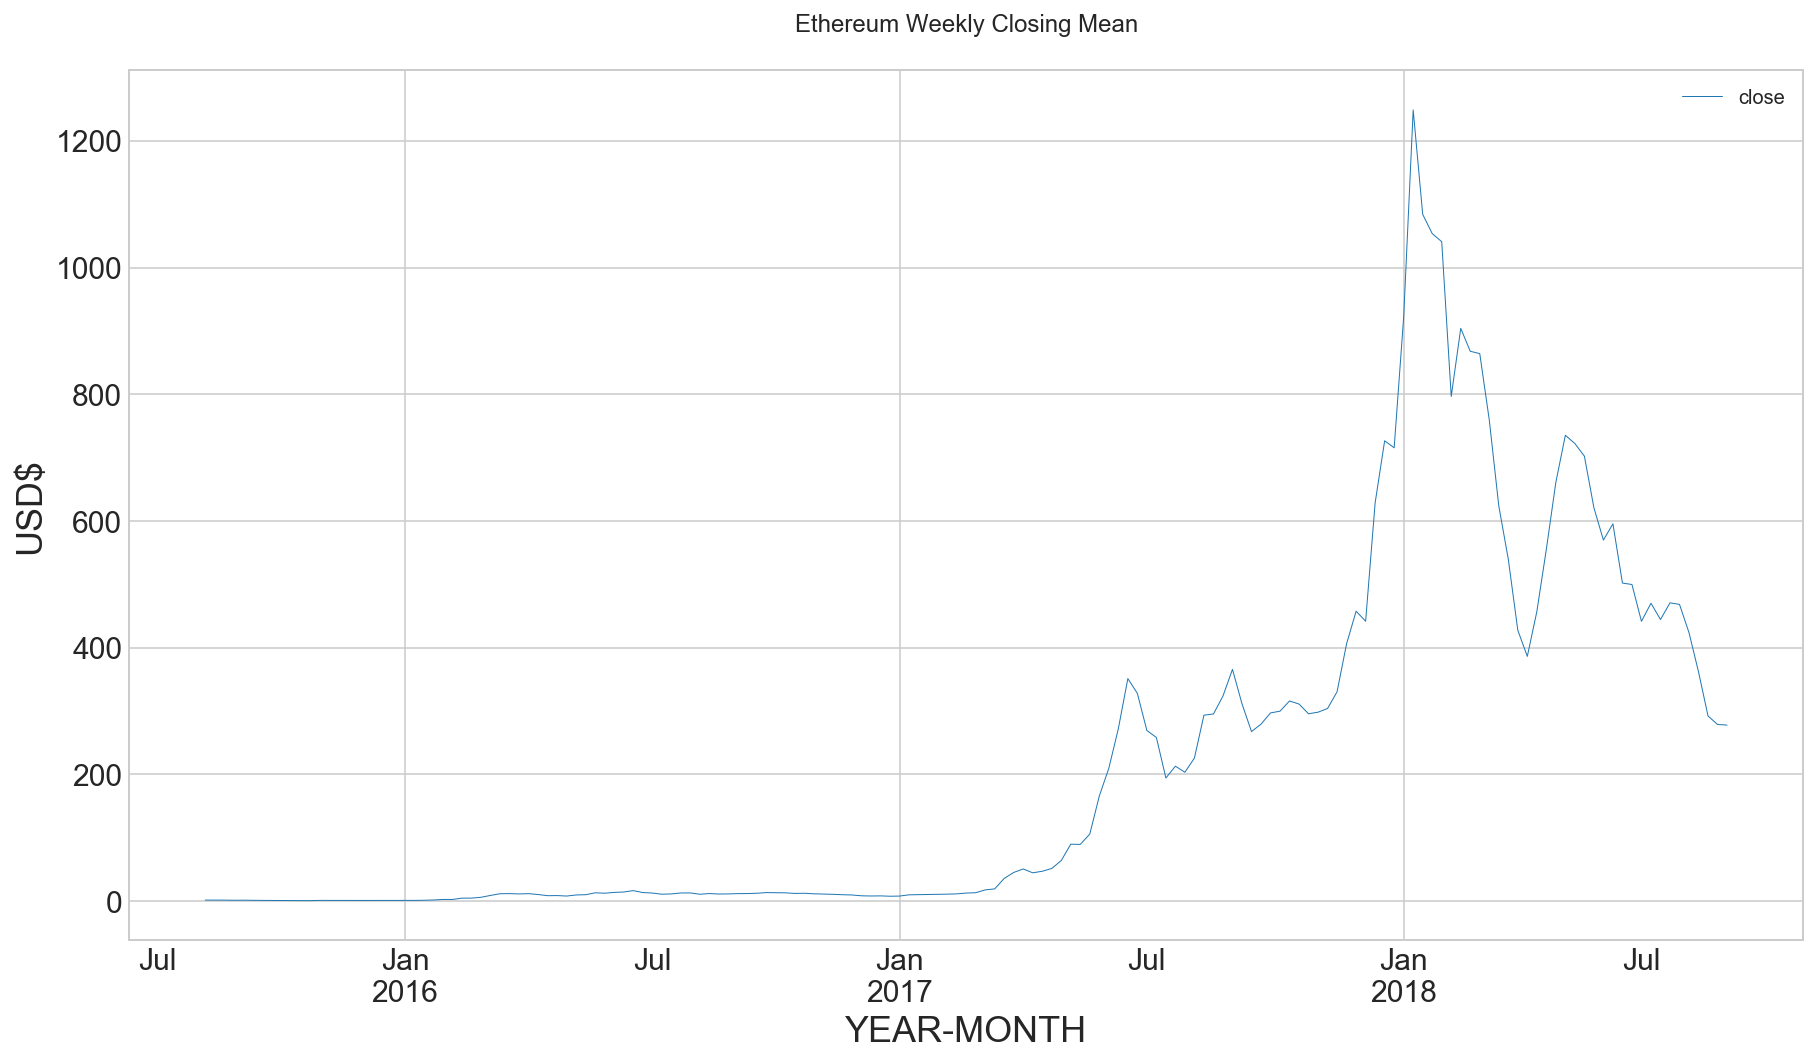

In [10]:
df_weeklyclose.plot(kind='line', lw='0.5', figsize=(15,8), title= 'Ethereum Weekly Closing Mean\n',  fontsize=15)
plt.ylabel('USD$', fontsize=18)
plt.xlabel('YEAR-MONTH', fontsize=18)
plt.show()

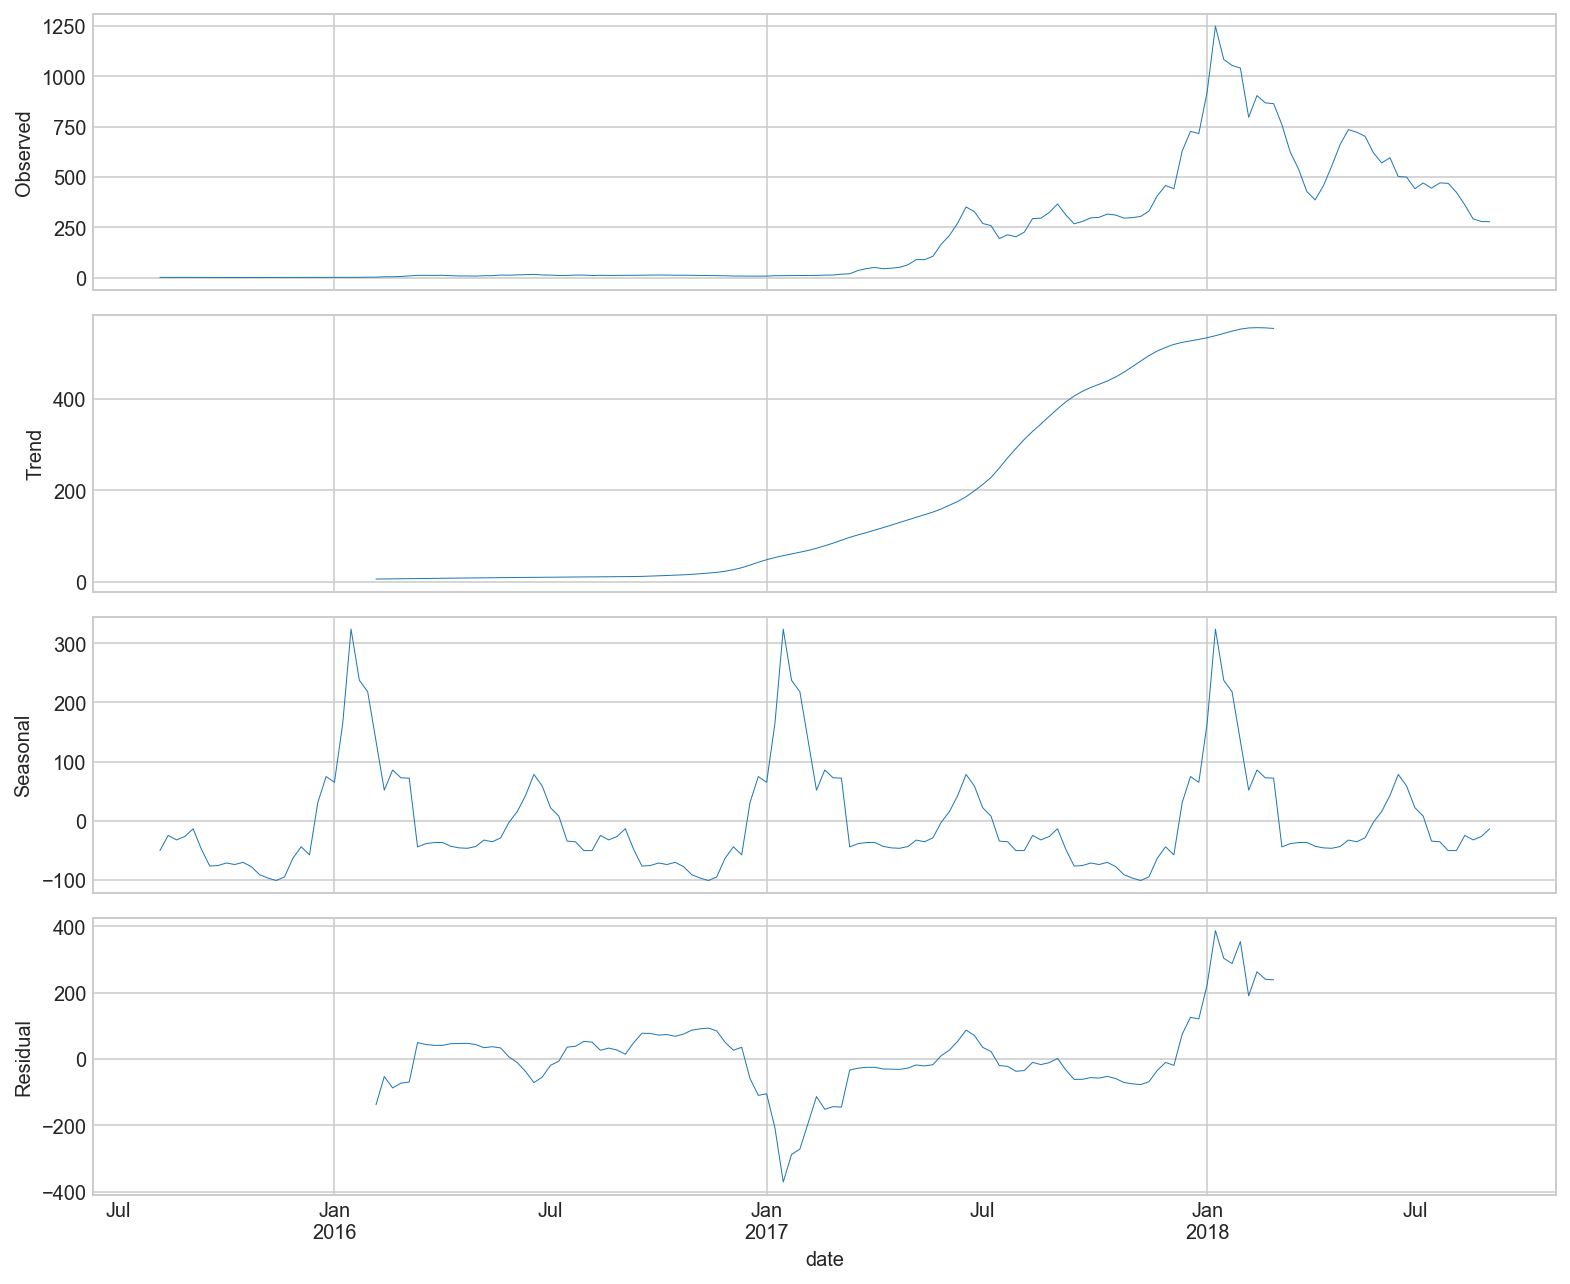

In [11]:
# Additive decomposition for non-log values. 
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
rcParams['lines.linewidth'] = 0.5

decomposition = seasonal_decompose(df_weeklyclose, model='additive')
fig = decomposition.plot()
plt.show()

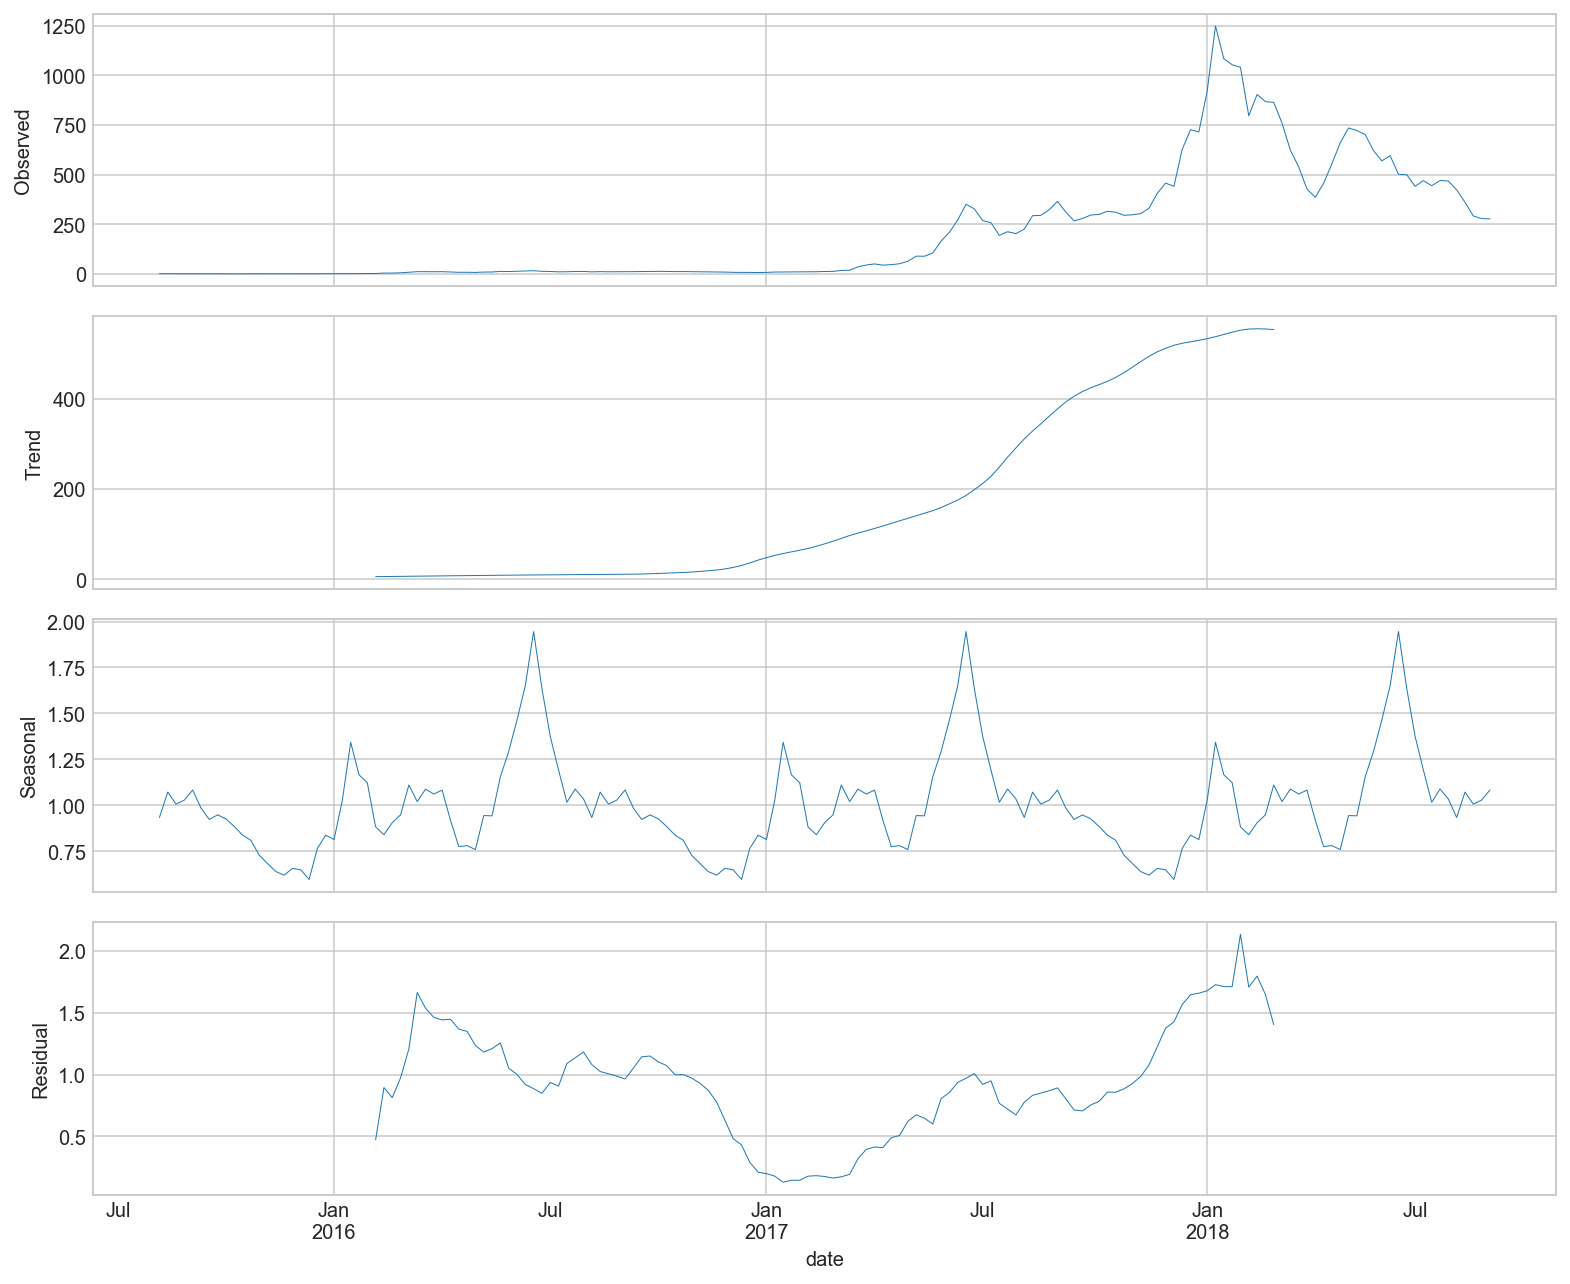

In [12]:
# Multiplicative decomposition for non-log values. 
decomposition = seasonal_decompose(df_weeklyclose, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [13]:
df_weeklyclose.head()

,close
date,
2015-08-09,1.423633
2015-08-16,1.453390
2015-08-23,1.376518
2015-08-30,1.165105
2015-09-06,1.262006


In [14]:
df_weeklyclose.tail(36)

,close
date,
2017-12-31,715.515988
2018-01-07,921.731883
2018-01-14,1248.853970
2018-01-21,1084.042723
2018-01-28,1053.722351
2018-02-04,1040.887075
2018-02-11,796.571307
2018-02-18,904.088317
2018-02-25,867.895698


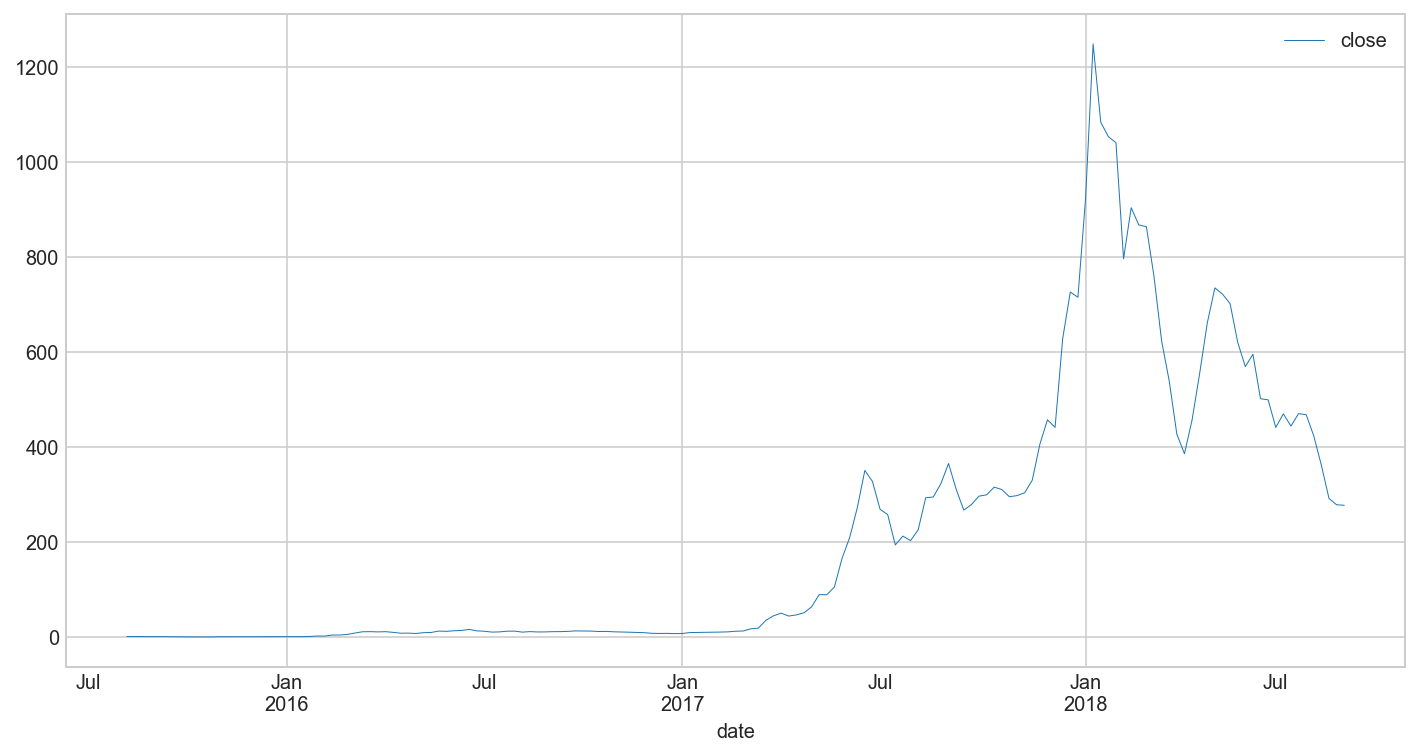

In [15]:
df_weeklyclose.plot(figsize=(12,6))

### Using Log Transformation

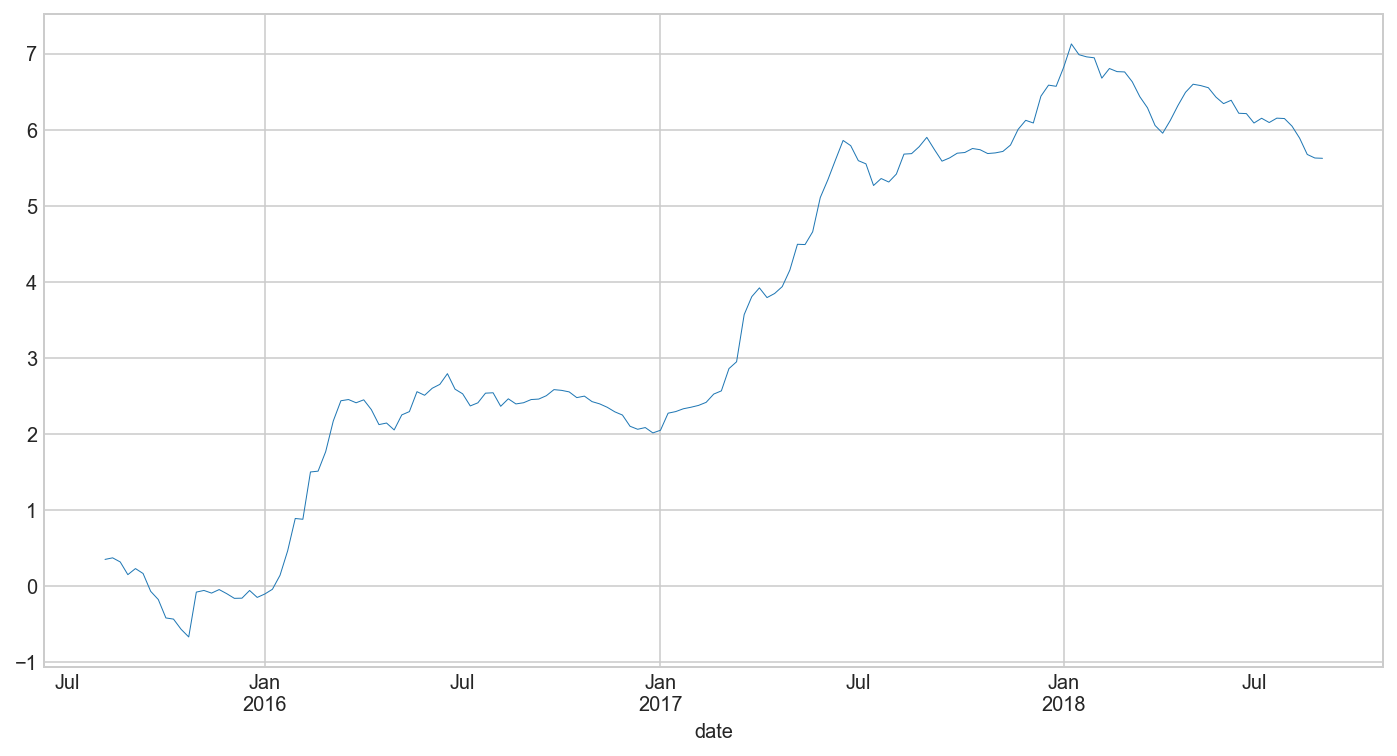

In [16]:
df_log = np.log(df_weeklyclose['close'])
df_log.plot(figsize=(12,6))

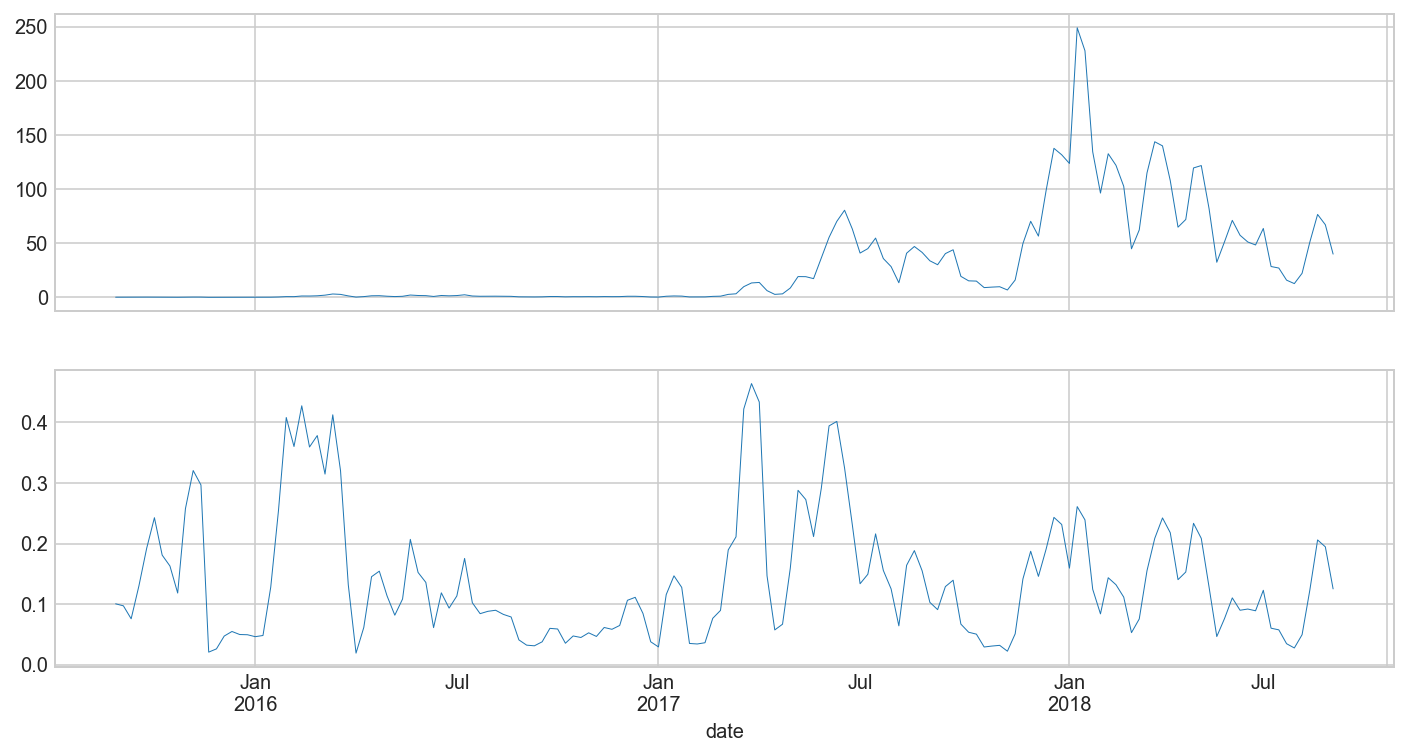

In [17]:
# Rolling Standard Deviation - orginal versus log transformed
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))
_ = df_weeklyclose['close'].rolling(4).std().plot(ax=ax1)
_ = df_log.rolling(4).std().plot(ax=ax2)

### Using Box-Cox Transformation

In [19]:
from scipy import special

def box_cox_rolling_coeffvar(box_cox_param, endog, freq):
    """helper to find Box-Cox transformation with constant standard deviation
    
    returns RLM results instance
    """
    roll_air = special.boxcox(endog, box_cox_param).rolling(window=freq)
    y = roll_air.std() 
    m = roll_air.mean()
    x = sm.add_constant(m)
    res_rlm = sm.RLM(y, x, missing='drop').fit()
    return res_rlm

endog = df_weeklyclose['close']
freq = 4
tt = [(lam, box_cox_rolling_coeffvar(lam, endog, freq).pvalues[1]) for lam in np.linspace(-1, 1, 21)]

tt = np.asarray(tt)
print(tt[tt[:,1].argmax()])

[0.         0.65508906]


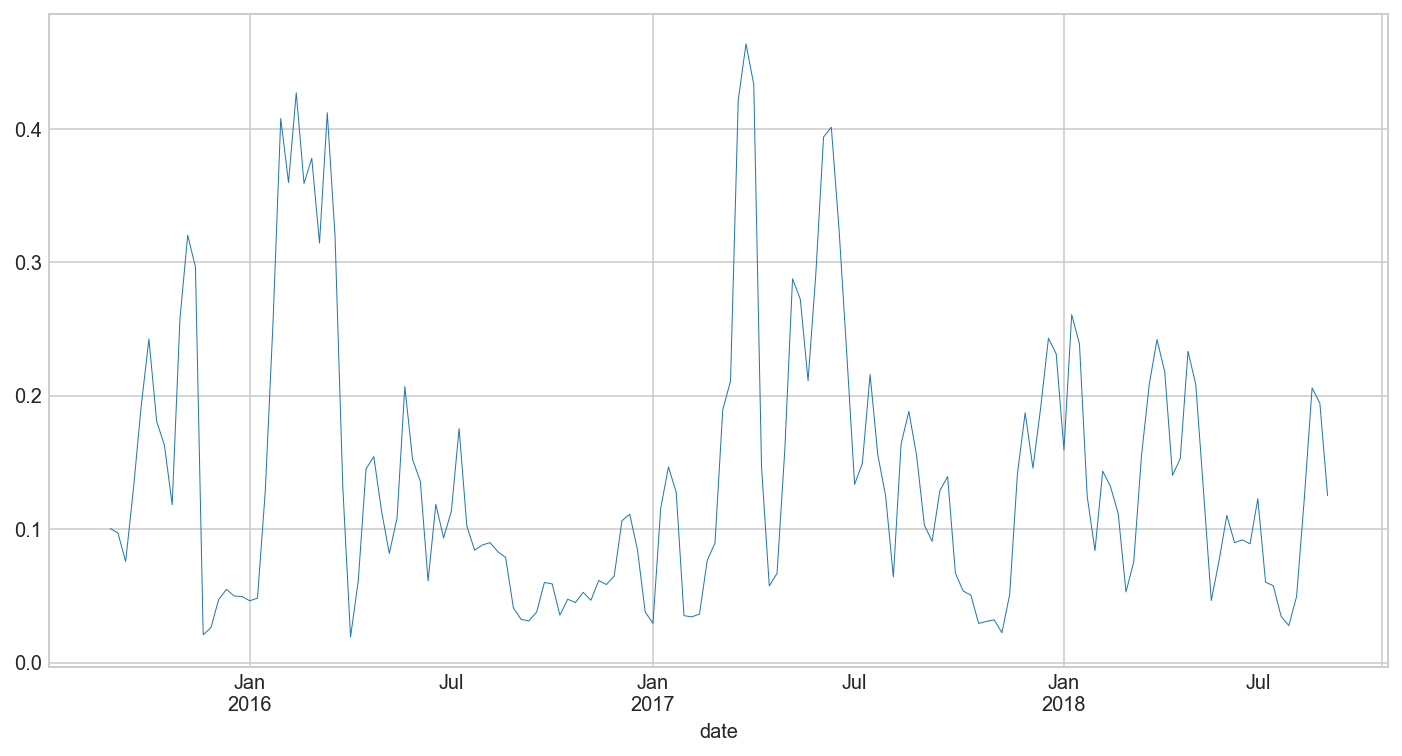

In [20]:
# Rolling Standard Deviation - Box-Cox transformed
ax = special.boxcox(df_weeklyclose['close'], 0).rolling(window=4).std().plot(figsize=(12,6))

In [21]:
weeklyclose_t = special.boxcox(df_weeklyclose['close'], 0)

One simple approach is to perform a grid search over multiple values of p,d,q using some sort of performance criteria. We can write a code to do a manual grid search or we can use the pyramid-arima library. The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object that you can fit to the training data. 

 The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

In [22]:
# Auto Arima
stepwise_model = auto_arima(weeklyclose_t, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-96.999, BIC=-81.592, Fit time=1.175 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-61.013, BIC=-48.687, Fit time=0.421 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-87.389, BIC=-75.063, Fit time=1.157 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-97.978, BIC=-79.490, Fit time=1.532 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=-65.483, BIC=-50.076, Fit time=0.831 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-98.688, BIC=-77.118, Fit time=2.126 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-89.492, BIC=-71.003, Fit time=2.381 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-98.943, BIC=-74.291, Fit time=3.739 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 2, 12);

The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.

The AIC value will allow us to compare how well a model fits the data and takes into account the complexity of a model, so models that have a better fit while using fewer features will receive a better (lower) AIC score than similar models that utilize more features. https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

The actual value of the AIC (or AICc), and whether it is positive or negative, means nothing. If you simply changed the units the data are expressed in, the AIC (and AICc) would change dramatically. But the difference between the AIC of the two alternative models would not change at all.
Bottom line: Ignore whether it is positive or negative. Just choose the smallest which is the most optimal for the case.

#### The output of our code suggests that using the model SARIMAX(2, 1, 0)x(0, 1, 1, 12) which yields the lowest AIC value of -97.012. We should therefore consider this to be optimal option out of all the models we have generated.

In [23]:
res_s = sm.tsa.SARIMAX(weeklyclose_t, order=(2, 1, 0), seasonal_order=(0, 1, 2, 12), enforce_stationarity=True, enforce_invertibility=True ).fit()
res_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  161
Model:             SARIMAX(2, 1, 0)x(0, 1, 2, 12)   Log Likelihood                  56.077
Date:                            Tue, 28 Aug 2018   AIC                           -102.154
Time:                                    11:50:13   BIC                            -86.747
Sample:                                08-09-2015   HQIC                           -95.899
                                     - 09-02-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2388      0.095      2.517      0.012       0.053       0.425
ar.L2          0.2284      0.073      3.121      0.002       0.085       0.372
ma.S.L12      -0.8101    167.604     -0.005      0.996    -329.307     327.687
ma.S.L24      -0.1900     31.778     -0.006      0.995     -62.474      62.094
sigma2         0.0227      3.810      0.006      0.995      -7.444       7.489
===================================================================================
Ljung-Box (Q):                       16.84   Jarque-Bera (JB):                 4.23
Prob(Q):                              1.00   Prob(JB):                         0.12
Heteroskedasticity (H):               0.59   Skew:                             0.22
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interpreting the model table

In [24]:
res_s.summary().tables[0]

Dep. Variable:,close,No. Observations:,161
Model:,"SARIMAX(2, 1, 0)x(0, 1, 2, 12)",Log Likelihood,56.077
Date:,"Tue, 28 Aug 2018",AIC,-102.154
Time:,11:50:23,BIC,-86.747
Sample:,08-09-2015,HQIC,-95.899
,- 09-02-2018,,
Covariance Type:,opg,,


In [25]:
res_s.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.2388,0.095,2.517,0.012,0.053,0.425
ar.L2,0.2284,0.073,3.121,0.002,0.085,0.372
ma.S.L12,-0.8101,167.604,-0.005,0.996,-329.307,327.687
ma.S.L24,-0.1900,31.778,-0.006,0.995,-62.474,62.094
sigma2,0.0227,3.810,0.006,0.995,-7.444,7.489


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 
The P>|z| column informs us of the significance of each feature weight. We only retain features for p < 0.05.

In [26]:
res_s.summary().tables[2]

Ljung-Box (Q):,16.84,Jarque-Bera (JB):,4.23
Prob(Q):,1.00,Prob(JB):,0.12
Heteroskedasticity (H):,0.59,Skew:,0.22
Prob(H) (two-sided):,0.07,Kurtosis:,3.71


 The Jarque-Bera test is a goodness-of-fit test of whether the data has the skewness and kurtosis of a normal distribution. The normal distribution has a skew of 0.22 and a kurtosis of 3.67.

### Plotting diagnostic tools

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
We need to ensure that the residuals of our model are randomly distributed with zero-mean and not serially correlate, i. e. we’d like the remaining information to be white noise. If the fitted seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.
The residual plot of the fitted model in the upper left corner appears do be white noise as it does not display obvious seasonality or trend behaviour. The histogram plot in the upper right corner pair with the kernel density estimation (red line) indicates that the time series is almost normally distributed. This is compared to the density of the standard normal distribution (green line). The correlogram (autocorrelation plot) confirms this resuts, since the time series residuals show low correlations with lagged residuals.
Although the fit so far appears to be fine, a better fit could be achieved with a more complex model.

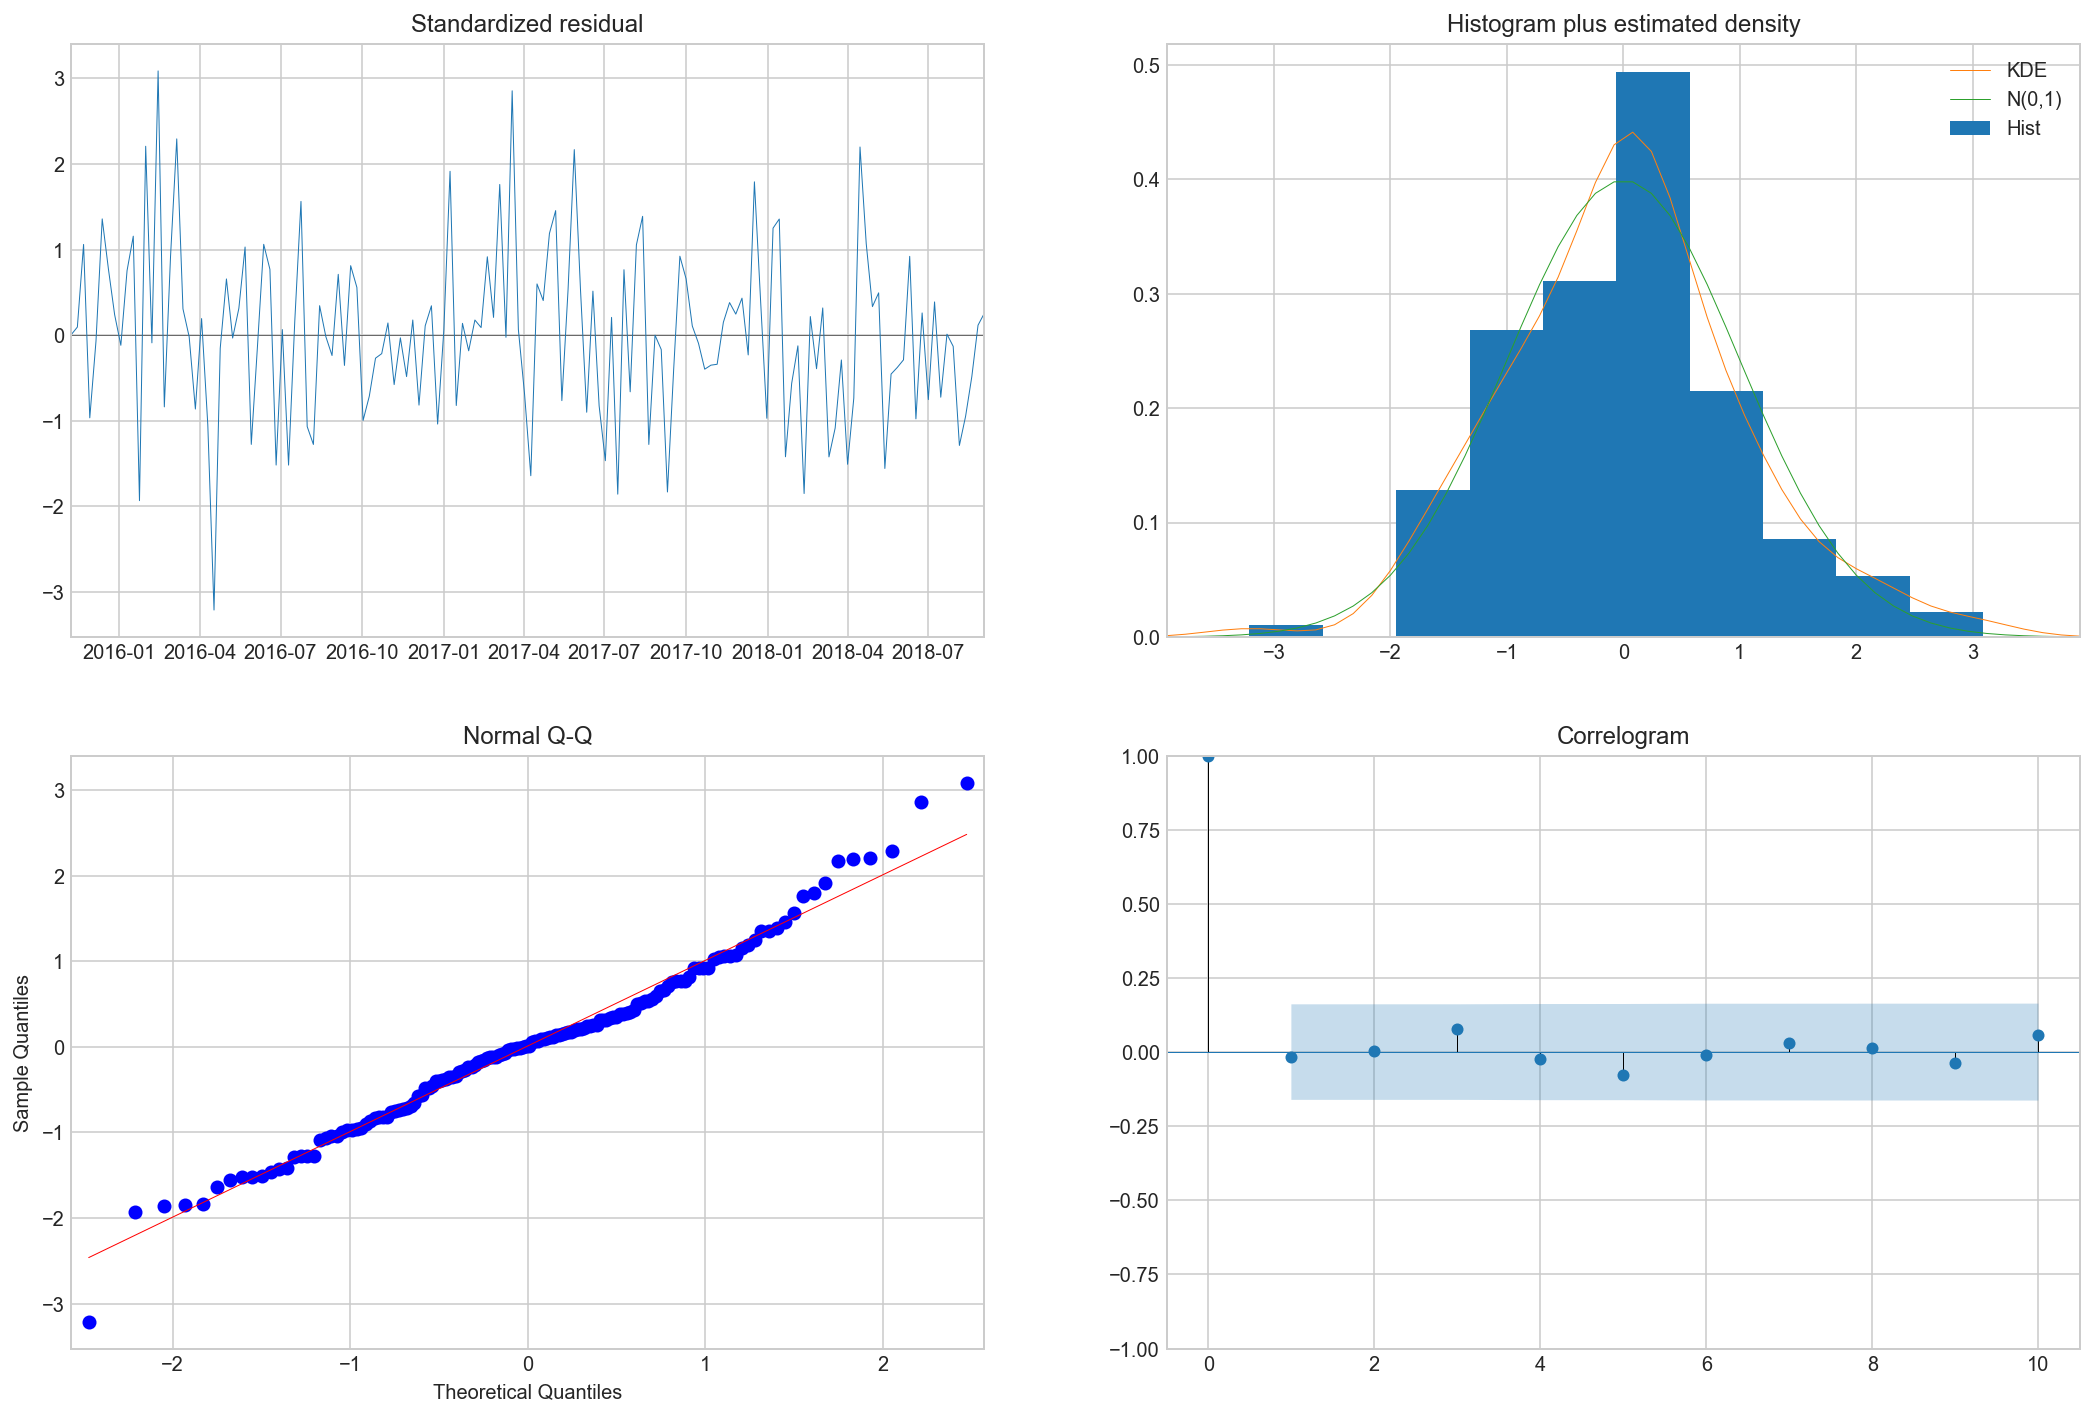

In [27]:
res_s.plot_diagnostics(figsize=(18, 12))
plt.show()

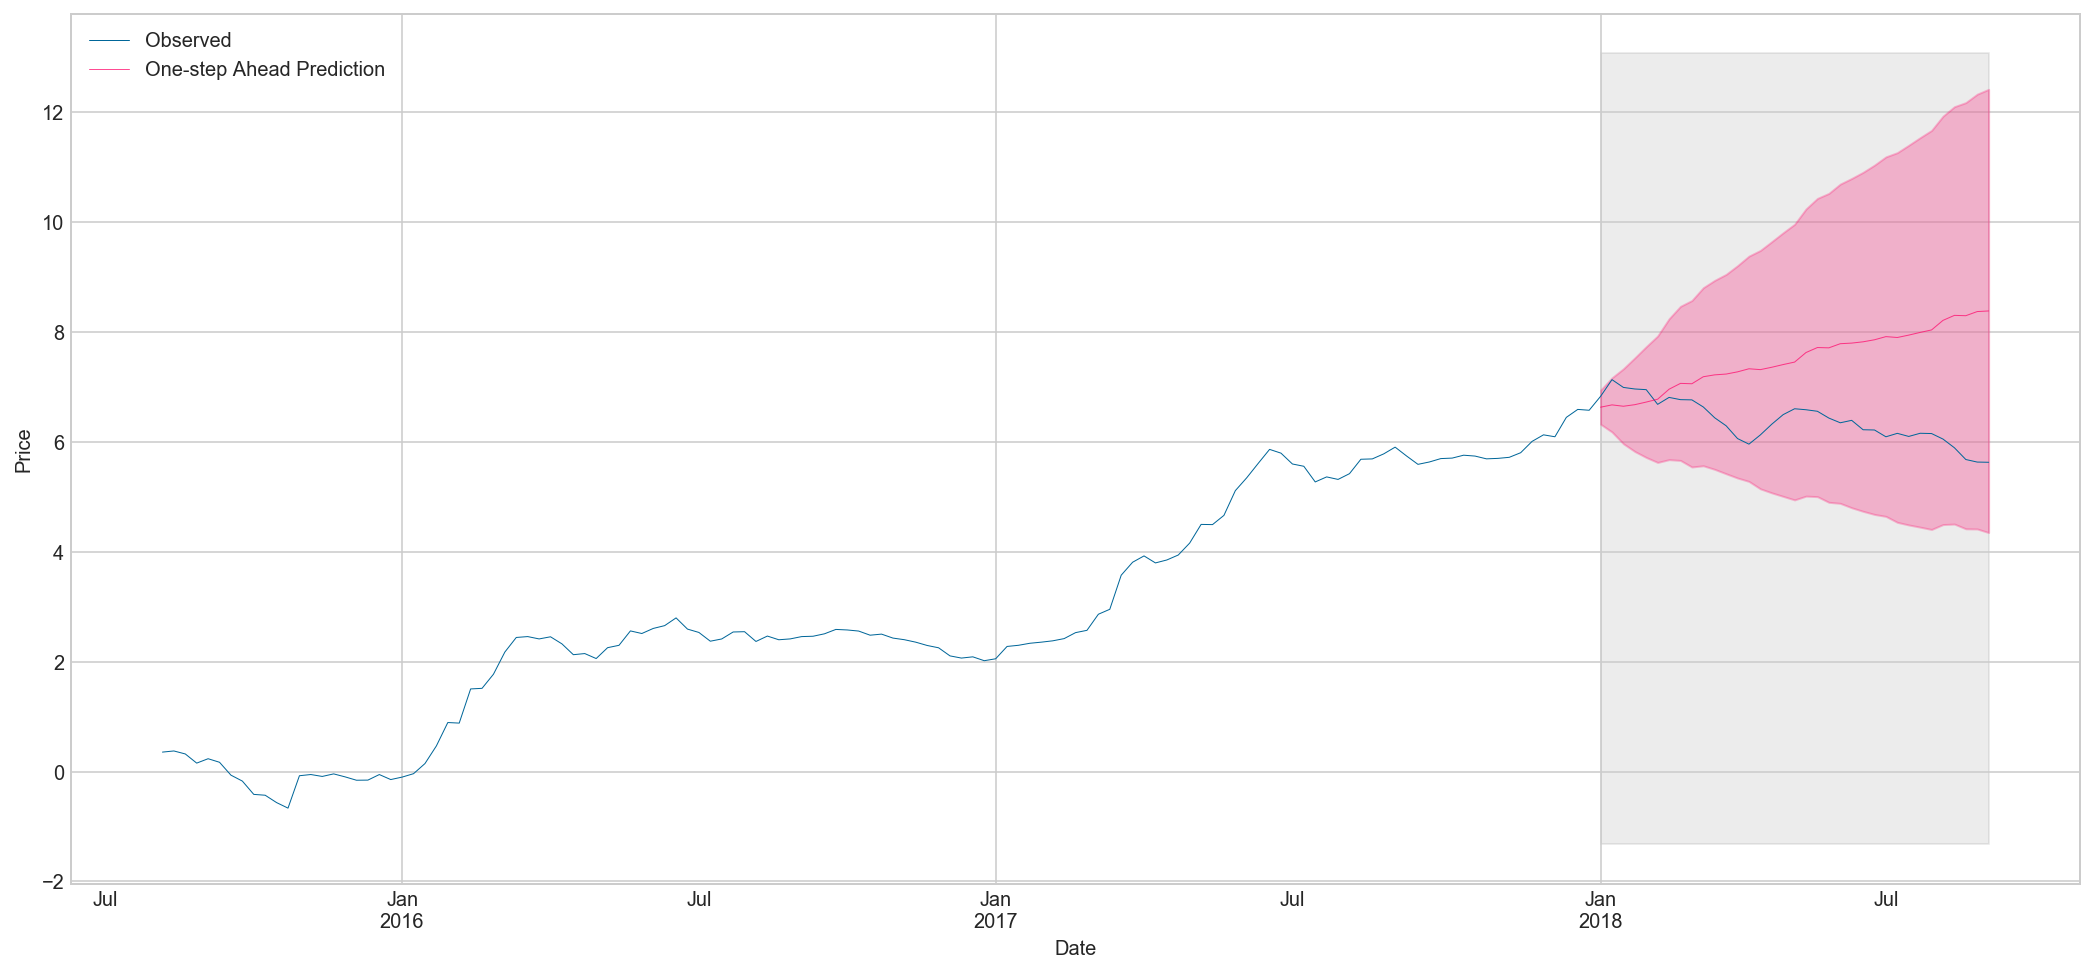

In [38]:
# in-sample-prediction and confidence bounds
pred = res_s.get_prediction(start=pd.to_datetime('2018-01-07'), 
                          end=pd.to_datetime('2018-09-02'),
                          dynamic=True, full_results=True)

pred_ci = pred.conf_int()

plt.figure(figsize=(18, 8))

# plot in-sample-prediction
ax = weeklyclose_t['2015-08-09':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-07'), weeklyclose_t.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [39]:
import math
y_hat = pred.predicted_mean
y_true = weeklyclose_t['2018-01-07':]
 
# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))


Prediction quality: 2.07 MSE (1.44 RMSE)


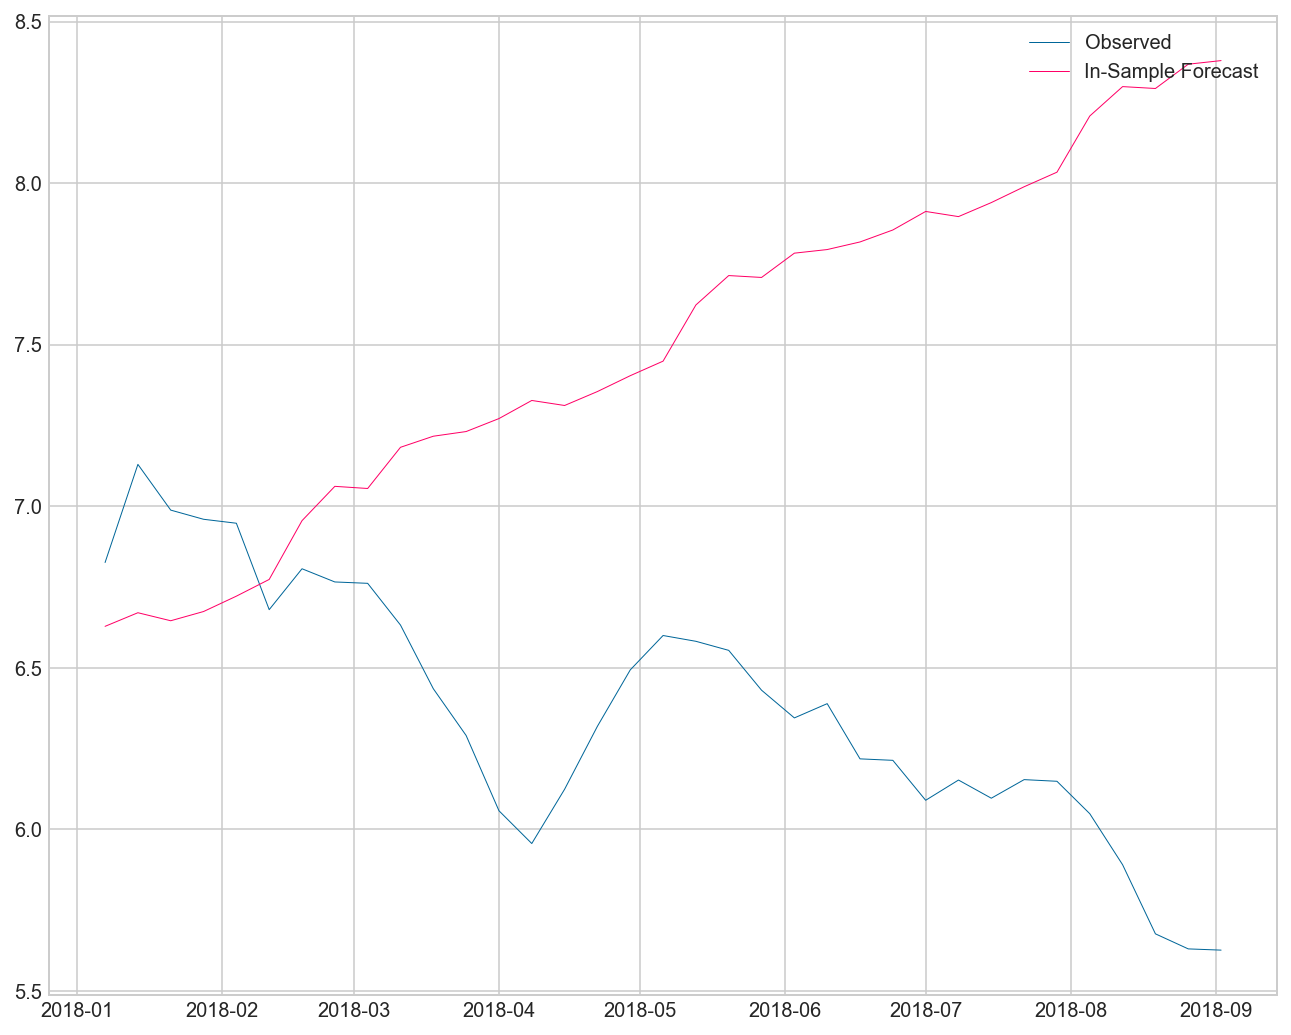

In [40]:
plt.plot(y_true, label='Observed', color='#006699')
plt.plot(y_hat, label='In-Sample Forecast', color='#ff0066')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend(loc='upper right');
plt.show()



The model shows a predicted steady climb but in actual fact, it went down.

In [41]:
# Out of sample forecast
pred = res_s.get_prediction(start=pd.to_datetime('2018-08-19'), end=pd.to_datetime('2018-12-19'))
pred_ci = pred.conf_int()

In [42]:
pred_ci.head()

,lower close,upper close
2018-08-19,5.446051,6.058989
2018-08-26,5.305529,5.918380
2018-09-02,5.280268,5.893119
2018-09-09,5.267213,5.880064
2018-09-16,5.109920,6.085614


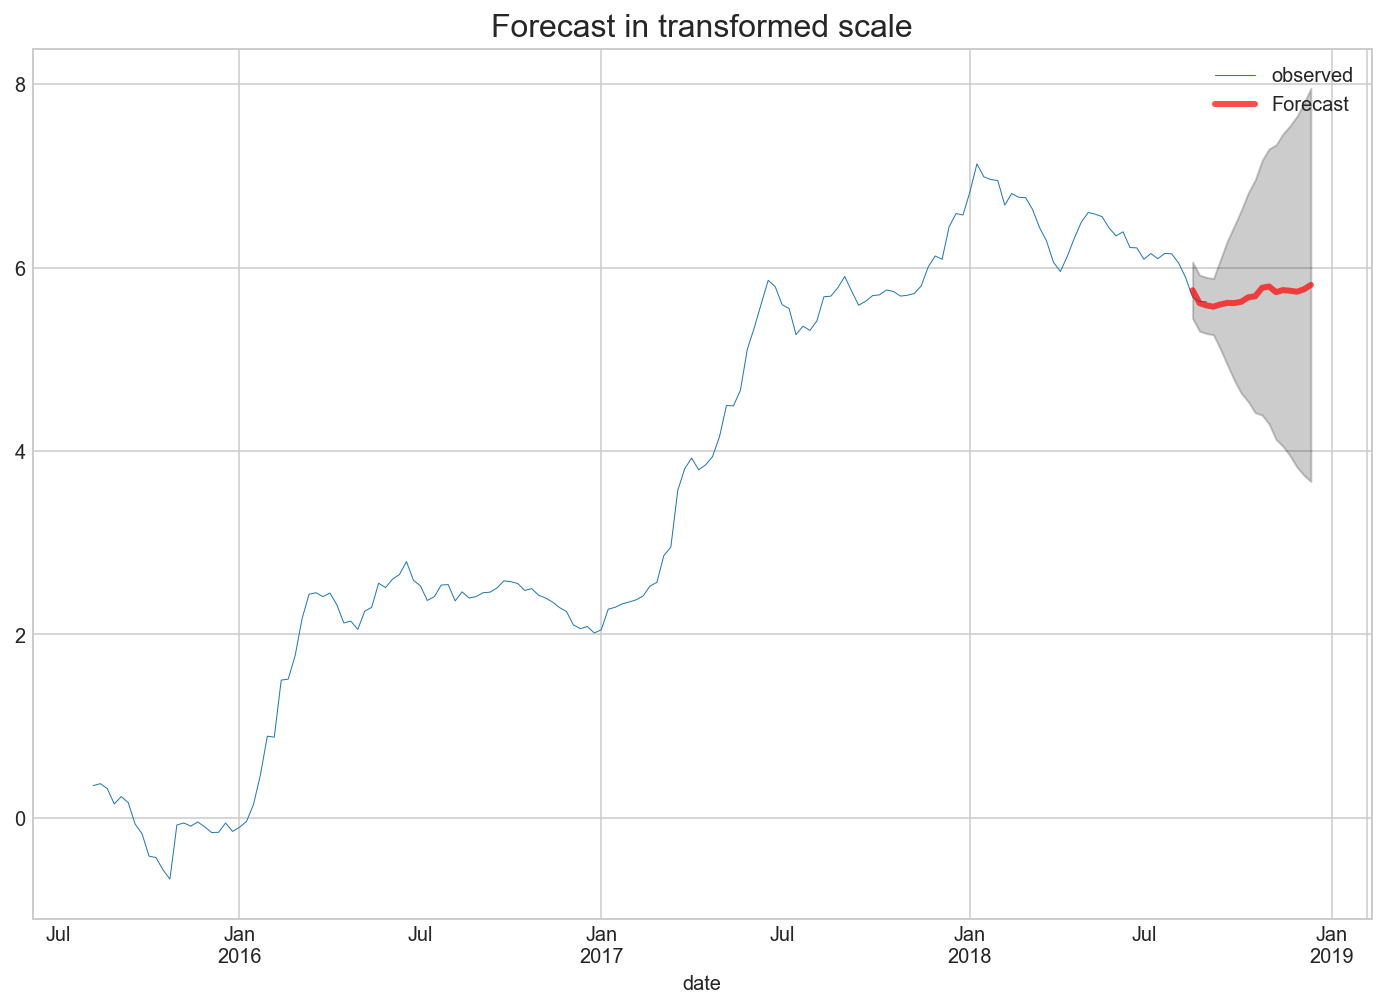

In [43]:
endog = weeklyclose_t
ax = endog.plot(label='observed')
ax.figure.set_size_inches(12, 8)
pred.predicted_mean.plot(ax=ax, label='Forecast', lw=3, alpha=.7, color='r')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Forecast in transformed scale', fontsize=16)
_ = plt.legend()

In [44]:
#Transform forecast to original scale
pred_ci_orig = special.inv_boxcox(pred.conf_int(), 0)
forecast = special.inv_boxcox(pred.predicted_mean, 0)

In [47]:
pred.predicted_mean

2018-08-19    5.752520
2018-08-26    5.611955
2018-09-02    5.586693
2018-09-09    5.573639
2018-09-16    5.597767
2018-09-23    5.614810
2018-09-30    5.612434
2018-10-07    5.626959
2018-10-14    5.676072
2018-10-21    5.686770
2018-10-28    5.779747
2018-11-04    5.793579
2018-11-11    5.731246
2018-11-18    5.754448
2018-11-25    5.747092
2018-12-02    5.736273
2018-12-09    5.762457
2018-12-16    5.810321
Freq: W-SUN, dtype: float64

In [45]:
forecast.head()

2018-08-19    314.983375
2018-08-26    273.678642
2018-09-02    266.851774
2018-09-09    263.390724
2018-09-16    269.823244
Freq: W-SUN, dtype: float64

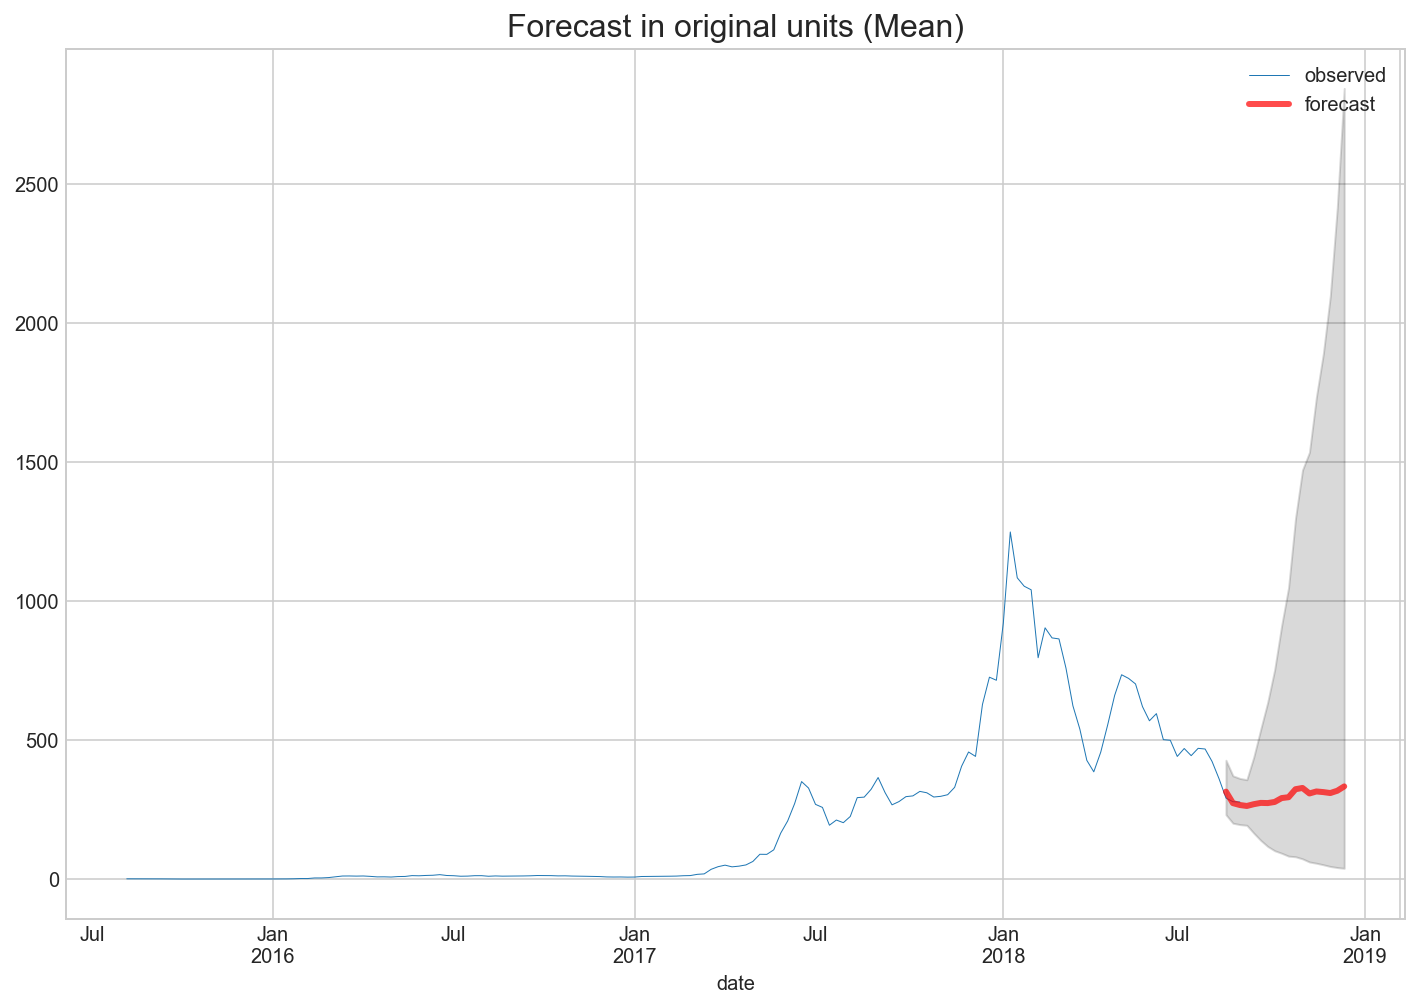

In [46]:
ax = df_weeklyclose['close'].plot(label='observed')
ax.figure.set_size_inches(12, 8)
forecast.plot(ax=ax, label='forecast', lw=3, alpha=.7, color='r')
ax.fill_between(pred_ci_orig.index,
                pred_ci_orig.iloc[:, 0],
                pred_ci_orig.iloc[:, 1], color='k', alpha=.15)
ax.set_title('Forecast in original units (Mean)', fontsize=16)
plt.legend();


As we forecast further out into the future, it is natural for the model to become less confident in its values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

We also noticed the predicted values regularly mirror the previous values.